In [1]:
#Import all the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys 
import os
import pickle
import tensorflow as tf
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, MaxPool2D
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.models import Sequential
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

In [2]:
#Set all the Constants
batchSize = 32
imageSize = 256
channels=3
epoch = 70 

In [3]:
#Import data into tensorflow dataset object()
imageDataset = tf.keras.preprocessing.image_dataset_from_directory(
    "SKINDISEASE DATASET", seed=123, shuffle=True, image_size=(imageSize,imageSize), batch_size=batchSize
)

Found 1400 files belonging to 4 classes.


In [4]:
#Check for dataset classes
classNames = imageDataset.class_names
classNames

['Acne and Rosacea',
 'Eczema',
 'Melanoma Skin Cancer Nevi and Moles',
 'Psoriasis']

In [5]:
#Check for dataset bacth size
for image_batch,label_batch in imageDataset.take(1):
    print(image_batch.shape)

(32, 256, 256, 3)


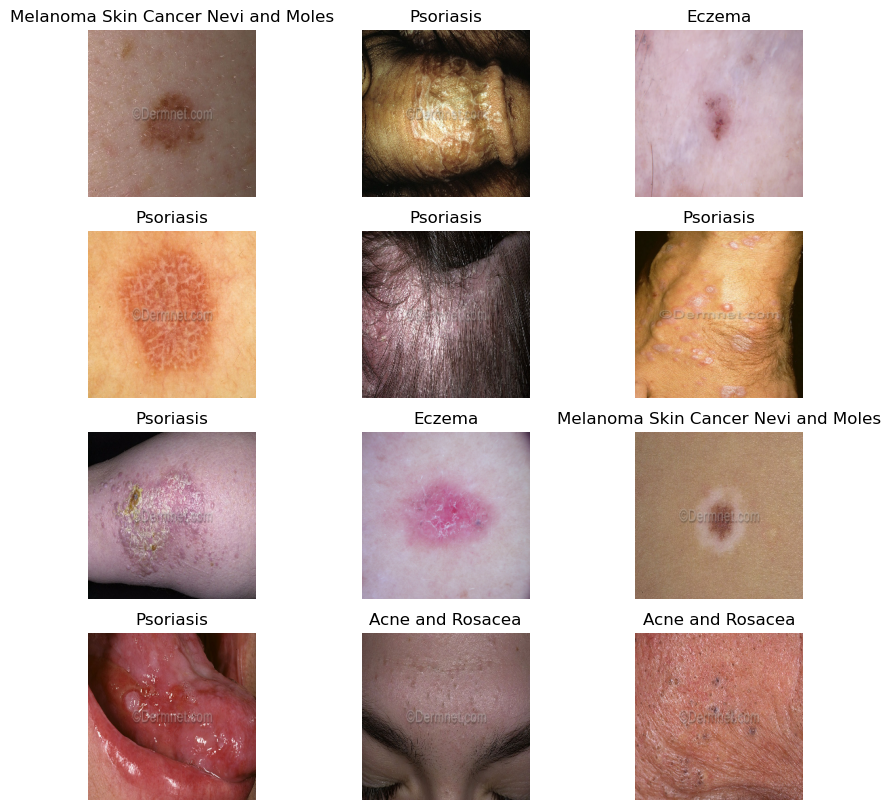

In [6]:
#VGet some images from the dataset
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in imageDataset.take(1):
    for i in range(12):
        shuffle = True
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classNames[labels_batch[i]])
        plt.axis("off")

In [7]:
#Function to split Dataset
#80% taken as training data
#10% taken as validation data
#10% taken as testing data

In [8]:
def get_dataset_partitions_tf(ds, trainSplit=0.8, valSplit=0.1, testSplit=0.1, shuffle=True, shuffle_size=10000):
    assert (trainSplit + testSplit + valSplit) == 1
    
    datasetSize = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    trainSize = int(trainSplit * datasetSize)
    validationSize = int(valSplit * datasetSize)
    
    trainDataset = ds.take(trainSize)    
    validationDataset = ds.skip(trainSize).take(validationSize)
    testDataset = ds.skip(trainSize).skip(validationSize)
    
    return trainDataset, validationDataset, testDataset

In [9]:
trainDataset, validationDataset, testDataset = get_dataset_partitions_tf(imageDataset)

In [10]:
#Cache, shuffle and Prefetch the Dataset
trainDataset = trainDataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validationDataset = validationDataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
testDataset = testDataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
#Building the model
#Creating a layer for resizing and normalization

In [12]:
#Data Pre-processing
resize_and_rescale = tf.keras.Sequential([layers.experimental.preprocessing.Resizing(imageSize, imageSize),
  layers.experimental.preprocessing.Rescaling(1./255),])

In [13]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), 
                                         layers.experimental.preprocessing.RandomRotation(0.2),])

In [14]:
#Applying Data Augmentation to Train Dataset
trainDataset = trainDataset.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
#CNN model archiecture using sequential class
input_shape = (batchSize, imageSize, imageSize, channels)
classVal = 4

model = models.Sequential([resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
                           
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),                    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
                           
    layers.Flatten(),          
    layers.Dense(64, activation='relu'),
    layers.Dense(classVal, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [17]:
#Compiling the Model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [18]:
history = model.fit(trainDataset, batch_size=batchSize, validation_data=validationDataset, verbose=1, epochs=epoch,)

Epoch 1/70
35/35 [==============================] - 65s 2s/step - loss: 1.3697 - accuracy: 0.2833 - val_loss: 1.4507 - val_accuracy: 0.2109
Epoch 2/70
35/35 [==============================] - 53s 1s/step - loss: 1.1812 - accuracy: 0.4353 - val_loss: 1.0666 - val_accuracy: 0.4141
Epoch 3/70
35/35 [==============================] - 42s 1s/step - loss: 0.9905 - accuracy: 0.5387 - val_loss: 0.9477 - val_accuracy: 0.6016
Epoch 4/70
35/35 [==============================] - 27s 767ms/step - loss: 0.9006 - accuracy: 0.6169 - val_loss: 1.0809 - val_accuracy: 0.5078
Epoch 5/70
35/35 [==============================] - 28s 806ms/step - loss: 0.8800 - accuracy: 0.6133 - val_loss: 0.8420 - val_accuracy: 0.6484
Epoch 6/70
35/35 [==============================] - 28s 789ms/step - loss: 0.7968 - accuracy: 0.6565 - val_loss: 0.8849 - val_accuracy: 0.5859
Epoch 7/70
35/35 [==============================] - 30s 854ms/step - loss: 0.8008 - accuracy: 0.6385 - val_loss: 0.8406 - val_accuracy: 0.6094
Epoch 8/

35/35 [==============================] - 501s 15s/step - loss: 0.4939 - accuracy: 0.7896 - val_loss: 0.7793 - val_accuracy: 0.6953
Epoch 59/70
35/35 [==============================] - 28s 800ms/step - loss: 0.5492 - accuracy: 0.7698 - val_loss: 0.6824 - val_accuracy: 0.7266
Epoch 60/70
35/35 [==============================] - 28s 801ms/step - loss: 0.4750 - accuracy: 0.7932 - val_loss: 0.6910 - val_accuracy: 0.7422
Epoch 61/70
35/35 [==============================] - 31s 873ms/step - loss: 0.4613 - accuracy: 0.8049 - val_loss: 0.7859 - val_accuracy: 0.7109
Epoch 62/70
35/35 [==============================] - 31s 865ms/step - loss: 0.4739 - accuracy: 0.8022 - val_loss: 0.6790 - val_accuracy: 0.7578
Epoch 63/70
35/35 [==============================] - 32s 873ms/step - loss: 0.4615 - accuracy: 0.8058 - val_loss: 0.6678 - val_accuracy: 0.7578
Epoch 64/70
35/35 [==============================] - 38s 1s/step - loss: 0.4503 - accuracy: 0.8165 - val_loss: 0.8228 - val_accuracy: 0.7031
Epoch 65

In [19]:
scores = model.evaluate(testDataset)

5/5 [==============================] - 4s 291ms/step - loss: 0.3672 - accuracy: 0.8500


In [20]:
scores

[0.3671940863132477, 0.8500000238418579]

In [21]:
print("Model accuracy")
scores = model.evaluate(testDataset)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

Model accuracy
5/5 [==============================] - 1s 259ms/step - loss: 0.3672 - accuracy: 0.8500
Test Accuracy: 85.0%


In [22]:
len(history.history['loss'])

70

In [23]:
history.history['loss'][:5]

[1.3696508407592773,
 1.1812294721603394,
 0.9904962778091431,
 0.9005603194236755,
 0.8800076246261597]

In [24]:
accuracy = history.history['accuracy']
validationAccuracy = history.history['val_accuracy']

loss = history.history['loss']
validationLoss = history.history['val_loss']

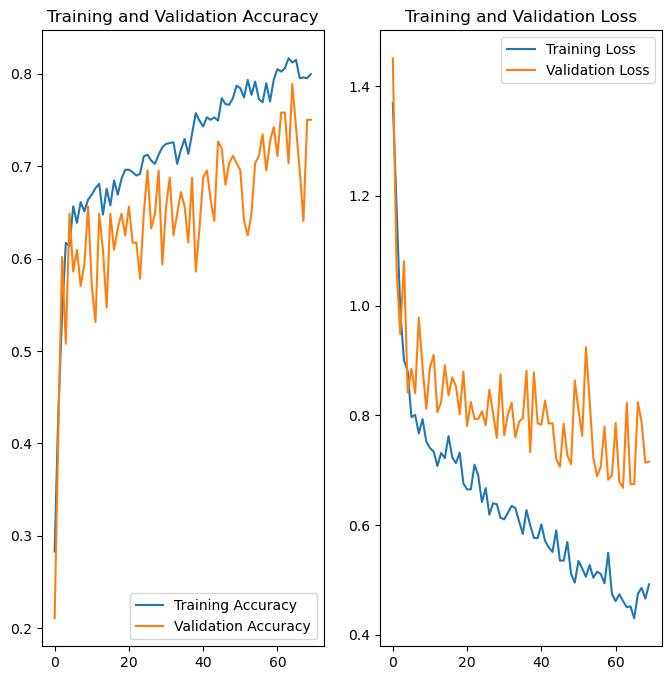

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epoch), accuracy, label='Training Accuracy')
plt.plot(range(epoch), validationAccuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epoch), loss, label='Training Loss')
plt.plot(range(epoch), validationLoss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
Actual disease: Acne and Rosacea
1/1 [==============================] - 1s 738ms/step
Predicted disease: Acne and Rosacea


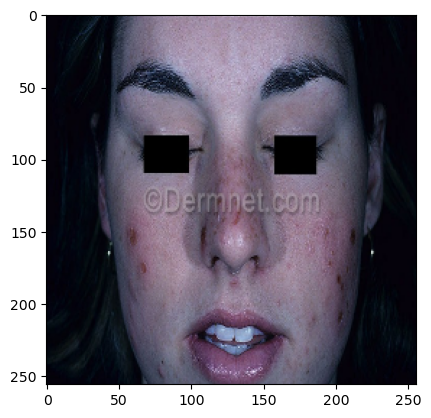

In [26]:
#Run test on a sample image
for images_batch, labels_batch in testDataset.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("Actual disease:",classNames[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted disease:",classNames[np.argmax(batch_prediction[0])])

In [27]:
#Write a function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classNames[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 51ms/step


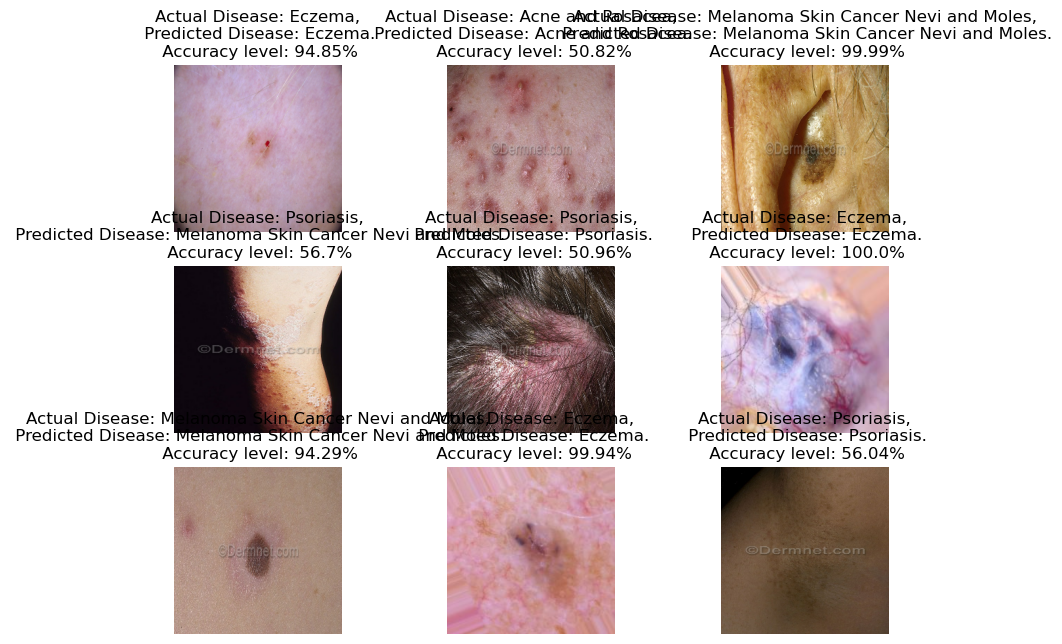

In [28]:
plt.figure(figsize=(10, 10))
for images, labels in testDataset.take(1):
    for i in range(9):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classNames[labels[i]] 
        plt.title(f"Actual Disease: {actual_class},\n Predicted Disease: {predicted_class}.\n Accuracy level: {confidence}%")
        plt.axis("off")

In [29]:
model_version=max([int(i) for i in os.listdir("../skinDiseaseDetection/models") + [0]])
model.save(f"../skinDiseaseDetection/models/{model_version}")

INFO:tensorflow:Assets written to: ../skinDiseaseDetection/models/6\assets


INFO:tensorflow:Assets written to: ../skinDiseaseDetection/models/6\assets


In [30]:
model.save("../model.h5")

In [31]:
filename = "CNN_model.pkl"
pickle.dump(model, open(filename,'wb')) 

INFO:tensorflow:Assets written to: ram://5c532936-7850-4387-bace-04e7cad3e9a4/assets


INFO:tensorflow:Assets written to: ram://5c532936-7850-4387-bace-04e7cad3e9a4/assets
